In [3]:
%run setup.py

In [10]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

from maelstrom.synthetic import SyntheticBinary
from maelstrom.utils import mass_function

In [4]:
# Check time delay signal is injected properly
period = 10.
eccen = 0.
asini = 500
varpi = 0.
tref = 0.

n_freq = 1
freqs = np.array([30])
amps = np.array([1])

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period, eccen, asini, varpi, tref, tau=True)
lc.add_noise(snr=80)
# plt.plot(*amplitude_spectrum(lc.time, lc.flux))

In [5]:
from tqdm import tqdm
from scipy.optimize import curve_fit

# This is a simple time delay model
def model(time, *theta):
    freq, amp, asini = np.reshape(theta, (3, len(freqs)))
    T_delay = 1 * (asini / 86400)
    
    res = np.zeros(len(time))
    for i in range(len(freq)):
        res += amp[i] * np.sin(2 * np.pi * freq[i] * (time - T_delay[0]))
    return res

Let's test that it works by choosing a random SNR..

In [6]:
snr = 1000

asinis = []
lc = SyntheticBinary(time, freqs, amps, period, eccen, asini, varpi, tref, tau=False)
s_rms = lc.amplitude.max() / (np.sqrt(np.pi / len(lc.time)) * snr)
for i in tqdm(range(5000)):
    noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
    x0 = np.array([freqs[0], amps[0], 0]).flatten()
    popt, pcov = curve_fit(model, lc.time, noisy_flux, p0=x0)
    asinis.append(popt[-1])

100%|██████████| 5000/5000 [00:17<00:00, 283.87it/s]


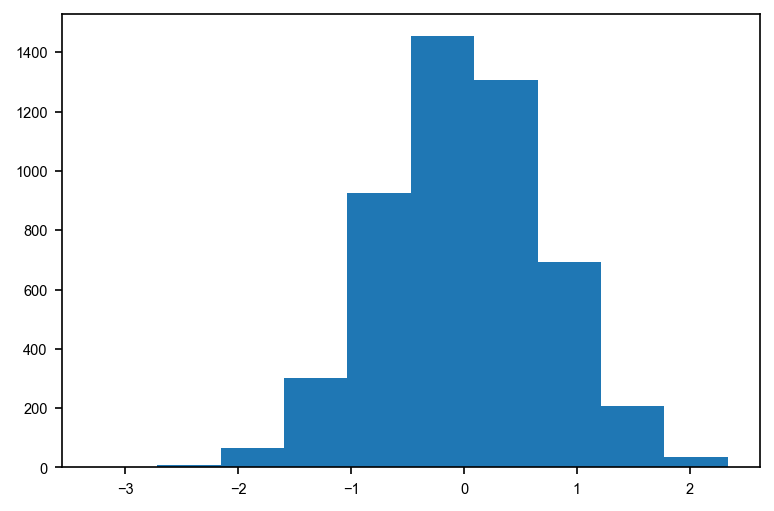

In [11]:
plt.hist(asinis);

Now let's do it for a range of SNRs. The vals below are the d Sct SNR percentiles obtained in previous notebook

In [12]:
vals = [14.6757, 1.4668, 0.72857]

In [13]:
from tqdm import tqdm

np.random.seed(42)
snrs = np.geomspace(10,1000,50)

asinis_sd = []
for snr in tqdm(snrs):
    asinis = []
    lc = SyntheticBinary(time, freqs, amps, period, eccen, asini, varpi, tref, tau=False)
    s_rms = lc.amplitude.max() / (np.sqrt(np.pi / len(lc.time)) * snr)
    for i in range(1000):
        noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
        x0 = np.array([freqs[0], amps[0], 0]).flatten()
        popt, pcov = curve_fit(model, lc.time, noisy_flux, p0=x0)
        asinis.append(popt[-1])
    asinis_sd.append(np.std(asinis))

100%|██████████| 50/50 [03:40<00:00,  4.42s/it]


In [17]:
from scipy import stats
import astropy.units as u

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(snrs), np.log(asinis_sd))

In [18]:
vals = [14.6757, 1.4668, 0.72857]

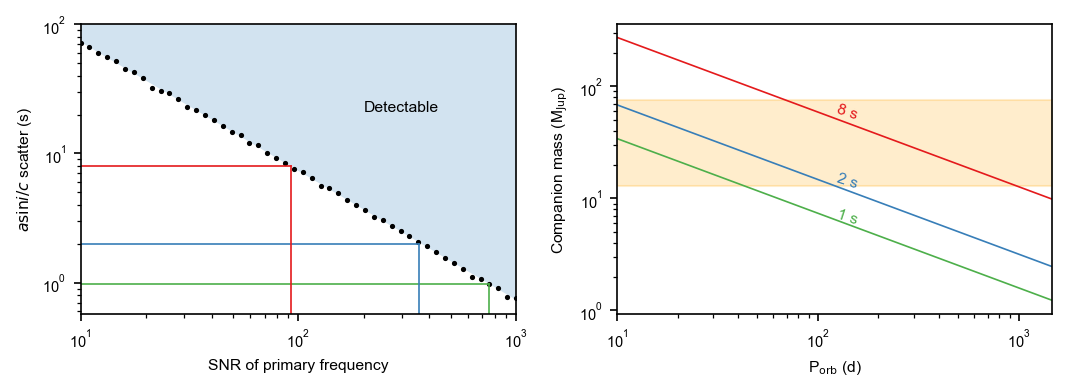

In [20]:
fig, axes = plt.subplots(1,2,
                         figsize=[7,2.5], 
                         constrained_layout=True)

linewidth=0.8
ax = axes[0]
ax.plot(snrs, asinis_sd, '.k', markersize=3, linewidth=0.7)
# ax.plot(snrs, np.exp((slope*np.log(snrs) + intercept)), '-.', c='black', linewidth=0.7)

ax.fill_between(snrs, 10**2,np.exp((slope*np.log(snrs) + intercept)), alpha=0.2)
ax.set_xscale('log')
ax.set_yscale('log')


ax.plot([0,92.1],[8,8],c=red, linewidth=linewidth)
ax.plot([0,358.4],[2,2], c=blue, linewidth=linewidth)
ax.plot([0,749.4],[0.96680069,0.96680069], c=green, linewidth=linewidth)

ax.plot([92.1,92.1],[0, 8],  c=red, linewidth=linewidth)
ax.plot([358.4,358.4],[0,2],  c=blue, linewidth=linewidth)
ax.plot([749.4,749.4],[0,0.96680069], c=green, linewidth=linewidth)

ax.set_xlabel('SNR of primary frequency')
ax.set_ylabel(r'$a\sin{i}/c$ scatter (s)')

ax.set_xlim(snrs[0], snrs[-1])
ax.set_ylim(None,10**2)


ax = axes[1]
periods = np.geomspace(10,1470,500)
stellar_mass = 1.8

worst_case = (mass_function(periods*u.day, 8*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)
typical_case = (mass_function(periods*u.day, 2*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)
best_case = (mass_function(periods*u.day, 1*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)

ax.plot(periods, worst_case, label='SNR=50', c=red, linewidth=linewidth)
ax.plot(periods, typical_case, label='SNR=500', c=blue, linewidth=linewidth)
ax.plot(periods, best_case, label='SNR=1000', c=green, linewidth=linewidth)

ax.fill_between(periods, 75, 13, alpha=0.2, color='orange')
ax.set_xlabel(r'P$_{\rm orb}$ (d)')
ax.set_ylabel(r'Companion mass (M$_{\rm Jup}$)')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_yticks([1,10,100])
ax.set_xlim(10,1470)

per_med = len(periods) // 2
ax.text(periods[per_med], worst_case[per_med].value, '8 s', rotation=-18, c=red)
ax.text(periods[per_med], typical_case[per_med].value-0.5, '2 s', rotation=-18, c=blue)
ax.text(periods[per_med], best_case[per_med].value-0.5, '1 s', rotation=-18, c=green)

axes[0].annotate('Detectable', (0.65,0.7), xycoords='axes fraction')
plt.savefig(overleaf_path + 'best_mass_range.pdf', dpi=300, bbox_inches='tight', pad_inches=0)